In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

nlp = spacy.load('en_core_web_lg')

2022-10-09 23:59:22.277386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 23:59:22.277402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/marko/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-10-09 23:59:23.926076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-09 23:59:23.926098: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-09 23:

In [2]:
# df.to_pickle("./pickle_files/df_spojeni_vectors.pkl")
# df = pd.read_pickle("./pickle_files/df_spojeni_vectors.pkl")
# df.to_pickle("./pickle_files/df_odvojeni_vectors.pkl")
# df = pd.read_pickle("./pickle_files/df_odvojeni_vectors.pkl")
# df.to_pickle("./pickle_files/df_odvojeni_word_vectors.pkl")
df = pd.read_pickle("./pickle_files/df_odvojeni_word_vectors.pkl")

In [3]:
#spajanje odvojenih postova

df = df.groupby(['type', 'avgWordLen'], sort=False,as_index=False).agg({'posts':' '.join,'upperCount':'first','stopWordCount':'first','urlCount':'first','wordCount':'first','avgWordLen':'first'})

In [4]:
df0 = df[df['type'] == 0].sample(450)
df1 = df[df['type'] == 1].sample(450)
df2 = df[df['type'] == 2].sample(450)
df3 = df[df['type'] == 3].sample(450)

df = pd.concat([df0, df1, df2, df3],)
df = df.reset_index().drop('index', axis=1)


In [5]:
sequence_length = 1703
max_features = 2000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'
# vectorize_layer = tf.keras.layers.TextVectorization(
#     max_tokens=max_features,
#     output_mode='int',
#     output_sequence_length=sequence_length)

# vectorize_layer.adapt(tf.expand_dims(df['posts'], axis=-1))

# vectors = vectorize_layer(tf.expand_dims(df['posts'], axis=-1))
# vectors
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, oov_token=oov_token)
tokenizer.fit_on_texts(df['posts'].array)
word_index= tokenizer.word_index
vectorList = tokenizer.texts_to_sequences(list(df['posts']))
vectorList = tf.keras.utils.pad_sequences(vectorList, padding=pad_type, truncating=trunc_type, maxlen=sequence_length,dtype='int32')

## NN ALGORITHMS

In [6]:
training_size = 0.8

sentences = []
labels = []

for ind in df.index:
    sentences.append(vectorList[ind])
    labels.append(df['type'][ind])

In [7]:
from sklearn.model_selection import train_test_split
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(sentences, labels, test_size=1-training_size, random_state=42, stratify=labels)

In [8]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [9]:
encoder = OneHotEncoder()
training_labels = encoder.fit_transform(training_labels.reshape(-1,1)).toarray()
testing_labels = encoder.fit_transform(testing_labels.reshape(-1,1)).toarray()

In [10]:
testing_sentences = np.array(list(testing_sentences))
training_sentences = np.array(list(training_sentences))
# testing_sentences = tf.convert_to_tensor(testing_sentences)
# training_sentences = tf.convert_to_tensor(training_sentences)

In [11]:
classes = 4

filters = 32
pool_size = 2
kernel_size = 3
embedding_dim = 128

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features + 1, embedding_dim,input_length=sequence_length),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid',activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size),
    tf.keras.layers.LSTM(120,return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(classes,activation='softmax')
])
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

2022-10-09 23:59:36.250510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
NEpoch = 32
batch_size = 32
history = model.fit(training_sentences, training_labels, batch_size=batch_size, epochs=NEpoch, validation_data=(testing_sentences, testing_labels))

Epoch 1/32
45/45 [==============================] - 16s 339ms/step - loss: 1.3878 - accuracy: 0.2431 - val_loss: 1.3861 - val_accuracy: 0.2500
Epoch 2/32
45/45 [==============================] - 15s 323ms/step - loss: 1.3865 - accuracy: 0.2562 - val_loss: 1.3846 - val_accuracy: 0.3444
Epoch 3/32
45/45 [==============================] - 15s 324ms/step - loss: 1.3889 - accuracy: 0.3097 - val_loss: 1.3763 - val_accuracy: 0.2833
Epoch 4/32
45/45 [==============================] - 15s 325ms/step - loss: 1.3523 - accuracy: 0.3076 - val_loss: 1.3757 - val_accuracy: 0.2639
Epoch 5/32
45/45 [==============================] - 15s 325ms/step - loss: 1.3596 - accuracy: 0.3215 - val_loss: 1.3386 - val_accuracy: 0.3722
Epoch 6/32
45/45 [==============================] - 15s 325ms/step - loss: 1.2657 - accuracy: 0.4181 - val_loss: 1.2169 - val_accuracy: 0.4306
Epoch 7/32
45/45 [==============================] - 14s 323ms/step - loss: 1.1378 - accuracy: 0.4785 - val_loss: 1.2437 - val_accuracy: 0.4333

In [13]:
model.save('saved_models/450Set_nospacy')
model.save('saved_models/450Set_nospacy.h5')

INFO:tensorflow:Assets written to: saved_models/450Set_nospacy/assets


INFO:tensorflow:Assets written to: saved_models/450Set_nospacy/assets


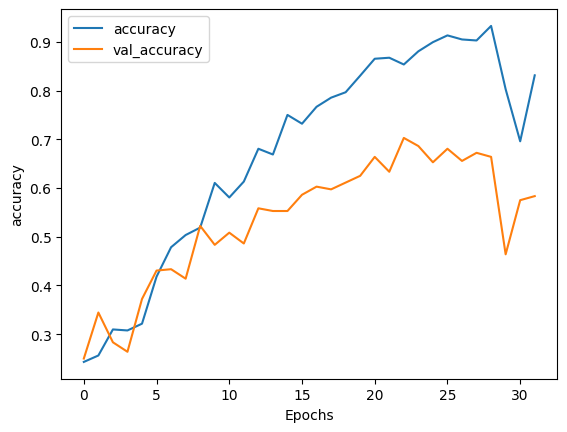

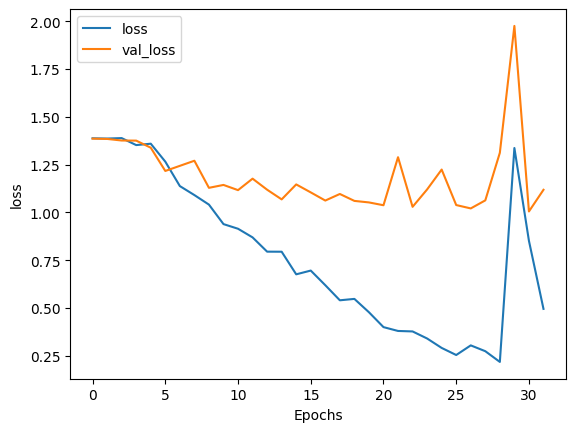

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [16]:
print(max(history.history['val_accuracy']))
print(min(history.history['val_loss']))


0.7027778029441833
1.0048961639404297


# Evaluation

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns


In [18]:
predict = model.predict(testing_sentences)

12/12 [==============================] - 1s 91ms/step


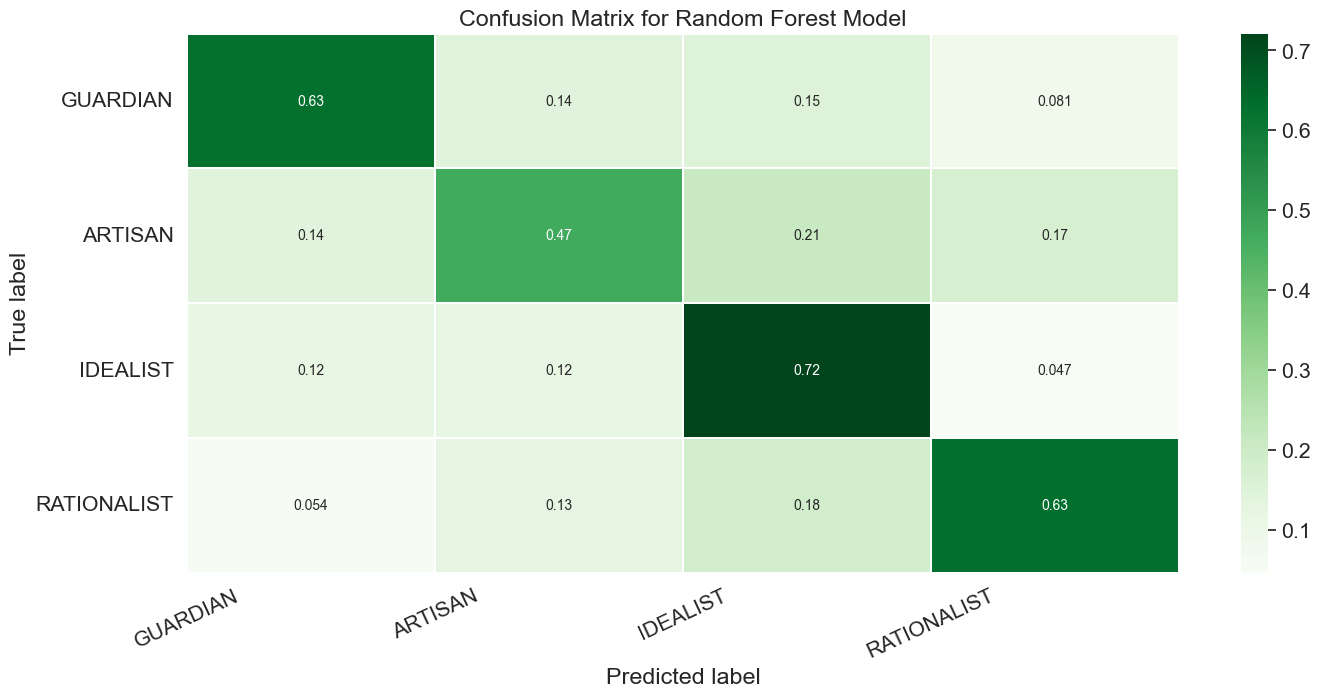

In [19]:
from math import isnan
################ CONFUSION MATRIX ####################
# Get and reshape confusion matrix data
matrix = confusion_matrix(np.argmax(predict,axis=1), np.argmax(testing_labels,axis=1))
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


for index1, i in enumerate(matrix):
  for index2, j in enumerate(i):
    if isnan(j):
      matrix[index1][index2] = 0;

# Build the plot
plt.figure(figsize=(16, 7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size': 10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['GUARDIAN', 'ARTISAN', 'IDEALIST', 'RATIONALIST']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()
################ CONFUSION MATRIX ####################


In [20]:
import sklearn.metrics as skm

pred_max = np.argmax(predict,axis=1)
test_max = np.argmax(testing_labels,axis=1)

print(skm.classification_report(test_max,pred_max))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66        90
           1       0.47      0.66      0.55        90
           2       0.72      0.34      0.47        90
           3       0.63      0.64      0.64        90

    accuracy                           0.58       360
   macro avg       0.61      0.58      0.58       360
weighted avg       0.61      0.58      0.58       360

